/var/folders/2g/1wnxcgv14rlfmx8gyxg7_w380000gn/T/ipykernel_16020/2050323825.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches_rolling = grouped.apply(lambda x: rolling_averages(x, cols, new_cols)).reset_index(drop=True)


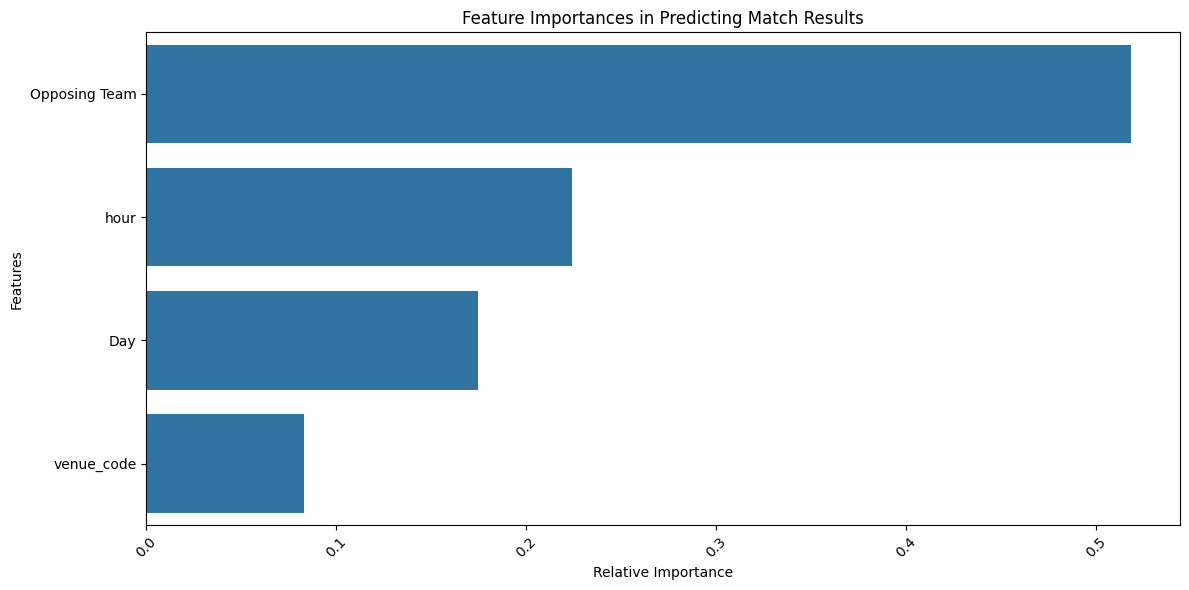

Match Prediction Accuracy: 60.28%
Precision: 45.28%
Precision with rolling averages: 0.625
actual_x
1    27
0    13
Name: count, dtype: int64
          date                     Team         Opponent predicted_result  \
0   2022-01-01                  Arsenal  Manchester City          Not Win   
1   2022-01-23                  Arsenal          Burnley          Not Win   
2   2022-02-10                  Arsenal           Wolves          Not Win   
3   2022-02-19                  Arsenal        Brentford          Not Win   
4   2022-02-24                  Arsenal           Wolves              Win   
..         ...                      ...              ...              ...   
263 2022-03-13  Wolverhampton Wanderers          Everton          Not Win   
264 2022-03-18  Wolverhampton Wanderers     Leeds United          Not Win   
265 2022-04-02  Wolverhampton Wanderers      Aston Villa          Not Win   
266 2022-04-08  Wolverhampton Wanderers    Newcastle Utd          Not Win   
267 2022-04

,date,Team,Opponent,predicted_result,actual_result
0,2022-01-01,Arsenal,Manchester City,Not Win,Not Win
1,2022-01-23,Arsenal,Burnley,Not Win,Not Win
2,2022-02-10,Arsenal,Wolves,Not Win,Win
3,2022-02-19,Arsenal,Brentford,Not Win,Win
4,2022-02-24,Arsenal,Wolves,Win,Win
...,...,...,...,...,...
263,2022-03-13,Wolverhampton Wanderers,Everton,Not Win,Win
264,2022-03-18,Wolverhampton Wanderers,Leeds United,Not Win,Not Win
265,2022-04-02,Wolverhampton Wanderers,Aston Villa,Not Win,Win
266,2022-04-08,Wolverhampton Wanderers,Newcastle Utd,Not Win,Not Win


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
matches = pd.read_csv("matches.csv", index_col=0)

# Convert date column to datetime
matches["date"] = pd.to_datetime(matches["date"], errors='coerce')

# Ensure time is a string and extract hour
matches["time"] = matches["time"].astype(str)
matches["hour"] = matches["time"].str.extract(r'(\d+)', expand=False).astype(float)

# Create categorical codes
matches["venue_code"] = matches["venue"].astype("category").cat.codes
matches["opp_code"] = matches["opponent"].astype("category").cat.codes

# Extract day of the week from date
matches["day_code"] = matches["date"].dt.dayofweek

# Create target variable
matches["target"] = (matches["result"] == "W").astype("int")

# Function for rolling averages
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]
new_cols = [f"{c}_rolling" for c in cols]

grouped = matches.groupby("team")
matches_rolling = grouped.apply(lambda x: rolling_averages(x, cols, new_cols)).reset_index(drop=True)

# Define predictors
predictors = ["venue_code", "opp_code", "hour", "day_code"]

# Train-Test Split
train = matches_rolling[matches_rolling["date"] < '2022-01-01']
test = matches_rolling[matches_rolling["date"] >= '2022-01-01']

# Train RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)
rf.fit(train[predictors], train["target"])

# Predictions
preds = rf.predict(test[predictors])

# Evaluation
acc = accuracy_score(test["target"], preds)
precision = precision_score(test["target"], preds)

# Visualize Feature Importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = [predictors[i] for i in indices]
feature_names = ["Opposing Team" if x == "opp_code" else "Day" if x == "day_code" else x for x in feature_names]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=feature_names)
plt.title("Feature Importances in Predicting Match Results")
plt.xlabel("Relative Importance")
plt.ylabel("Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display Prediction Accuracy and Precision
print(f"Match Prediction Accuracy: {acc * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")

# Making Predictions with Rolling Averages
def make_predictions(data, predictors):
    train = data[data["date"] < '2022-01-01']
    test = data[data["date"] >= '2022-01-01']
    rf.fit(train[predictors], train["target"])
    preds = rf.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test["target"], predicted=preds), index=test.index)
    precision = precision_score(test["target"], preds)
    return combined, precision

combined, precision = make_predictions(matches_rolling, predictors + new_cols)
print("Precision with rolling averages:", precision)

# Merging combined data
combined = combined.merge(matches_rolling[["date", "team", "opponent", "result"]], left_index=True, right_index=True)

# Mapping team names
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {
    "Brighton and Hove Albion": "Brighton",
    "Manchester United": "Manchester Utd",
    "Newcastle United": "Newcastle Utd",
    "Tottenham Hotspur": "Tottenham",
    "West Ham United": "West Ham",
    "Wolverhampton Wanderers": "Wolves"
}

mapping = MissingDict(**map_values)
combined["new_team"] = combined["team"].map(mapping)

# Final Merge and Evaluation
merged = combined.merge(combined, left_on=["date", "new_team"], right_on=["date", "opponent"])

result = merged[(merged["predicted_x"] == 1) & (merged["predicted_y"] == 0)]["actual_x"].value_counts()
print(result)

# Display the Matches Table with Predictions
merged["predicted_result"] = np.where(merged["predicted_x"] == 1, "Win", "Not Win")
merged["actual_result"] = np.where(merged["actual_x"] == 1, "Win", "Not Win")

display_columns = ["date", "team_x", "opponent_x", "predicted_result", "actual_result"]
matches_table = merged[display_columns].rename(columns={"team_x": "Team", "opponent_x": "Opponent"})

# Display the Matches Table
print(matches_table)

# Visualizing the Matches Table
print("\nMatch Prediction Accuracy: {:.2f}%".format(acc * 100))
print("\nPrecision with rolling averages: {:.2f}%".format(precision * 100))

display(matches_table)
